In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

float_type='float32'

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
from import_mnist import *

val_x=data_x[-10000:]
val_y=data_y[-10000:]
val_l=data_l[-10000:]
data_x=data_x[:-10000]
data_y=data_y[:-10000]
data_l=data_l[:-10000]

print(data_x.shape)
print(data_y.shape)
print(data_l.shape)

print(val_x.shape)
print(val_y.shape)
print(val_l.shape)

print(test_x.shape)
print(test_y.shape)
print(test_l.shape)

mean=tf.math.reduce_mean(np.arcsin(data_x**0.5),axis=0,keepdims=True).numpy()
std=tf.math.reduce_std(np.arcsin(data_x**0.5),axis=0,keepdims=True).numpy()

transf=lambda x: (np.arcsin(x**0.5)-mean)/(std+10**-20)
destransf=lambda x: np.sin(x*(std+10**-20)+mean)**2

data_x=transf(data_x)
val_x=transf(val_x)
test_x=transf(test_x)

(240000, 784)
(240000,)
(240000, 10)
(10000, 784)
(10000,)
(10000, 10)
(10000, 784)
(10000,)
(10000, 10)


In [6]:
wei_reg=tf.keras.regularizers.L2(0*10**-3)
enc_reg=tf.keras.regularizers.L2(10**-1)
zero=10**(-5)

# def enc_reg(x):
#     return -0.01 * tf.math.reduce_sum(0.001*tf.math.log(x+zero)+0.999*tf.math.log(1-x+zero))
    
    
mid_act='elu'
enc_act='linear'
end_act='softmax'

#loss=tf.keras.losses.MeanSquaredError()
#loss=tf.keras.losses.BinaryCrossentropy()
#loss=tf.keras.losses.BinaryCrossentropy()

class MSE(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):        
        
        return tf.reduce_mean(tf.math.square(y_pred - y_true))
    
class KS(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        
        
        return -2*tf.math.reduce_mean(y_true*tf.math.log(y_pred+zero)+(1-y_true)*tf.math.log(1-y_pred+zero))



custom_loss={"output1":tf.keras.losses.MeanSquaredError(),
             "output2":tf.keras.losses.BinaryCrossentropy()}

lossWeights = {"output1": 1.0, "output2": 3.0}

metrics=[]
optimizer = tf.keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

layers_encode=[
    tf.keras.layers.Reshape(           [28,28,1]                                                        ),
    tf.keras.layers.Conv2D(         32,[3,3], activation=mid_act,             kernel_regularizer=wei_reg),
    tf.keras.layers.AveragePooling2D(  [2,2]                                                            ),
    tf.keras.layers.Conv2D(         16,[4,4], activation=mid_act,             kernel_regularizer=wei_reg),
    tf.keras.layers.AveragePooling2D(  [2,2]                                                            ),
    tf.keras.layers.Flatten(                                                                            ),
    tf.keras.layers.Dense(          256,      activation=mid_act,             kernel_regularizer=wei_reg),
    tf.keras.layers.Dense(          2,        activation=enc_act,             kernel_regularizer=wei_reg,  activity_regularizer=enc_reg)
]
layers_decode1=[
    tf.keras.layers.Dense(          256,    activation=mid_act,              kernel_regularizer=wei_reg),
    tf.keras.layers.Dense(          5*5*16,   activation=mid_act,              kernel_regularizer=wei_reg),
    tf.keras.layers.Reshape(           [5,5,16]                                                          ),
    tf.keras.layers.Conv2DTranspose(32,[5,5], strides=(2,2), activation=mid_act,              kernel_regularizer=wei_reg),
    tf.keras.layers.Conv2DTranspose(1,[4,4], strides=(2,2), activation=mid_act,kernel_regularizer=wei_reg),
    tf.keras.layers.Conv2DTranspose(1,[1,1], strides=(1,1), activation='linear',kernel_regularizer=wei_reg),
    tf.keras.layers.Flatten(name="output1")
]

# layers_encode=[
#     tf.keras.layers.Dense(512, activation=mid_act,kernel_regularizer=wei_reg),
#     tf.keras.layers.Dense(256, activation=mid_act,kernel_regularizer=wei_reg),
#     tf.keras.layers.Dense(2,activity_regularizer=enc_reg)
# ]
layers_decode2=[
    #tf.keras.layers.Dense(256, activation=mid_act,kernel_regularizer=wei_reg),
    tf.keras.layers.Dense(16, activation=mid_act,kernel_regularizer=wei_reg),
    tf.keras.layers.Dense(10, activation=end_act,kernel_regularizer=wei_reg,name="output2")
]

enc_x=tf.keras.layers.Input([28*28])
dec_x=tf.keras.layers.Input([2])

encode=enc_x
for layer in layers_encode:
    encode=layer(encode)
    
decode_full1=encode
decode_full2=encode
decode_part1=dec_x
decode_part2=dec_x
for layer in layers_decode1:
    decode_full1=layer(decode_full1)
    decode_part1=layer(decode_part1)
    
for layer in layers_decode2:
    decode_full2=layer(decode_full2)
    decode_part2=layer(decode_part2)

Encoder=tf.keras.Model(enc_x, encode)
Decoder1=tf.keras.Model(dec_x, decode_part1)
Decoder2=tf.keras.Model(dec_x, decode_part2)
Network=tf.keras.Model(enc_x, [decode_full1,decode_full2])

Encoder.compile(loss=custom_loss,
              optimizer=optimizer,
              metrics=metrics)
Decoder1.compile(loss=custom_loss,
              optimizer=optimizer,
              metrics=metrics)
Decoder2.compile(loss=custom_loss,
              optimizer=optimizer,
              metrics=metrics)
Network.compile(loss=custom_loss,
              optimizer=optimizer,
              metrics=metrics,
                loss_weights=lossWeights)

In [7]:
def scheduler(epoch, lr):
    if epoch < 10:
        return 10**-2
    elif epoch<30:
        return 10**-3
    else:
        return 10**-4
callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [18]:
Model_name='Model_hibrid'

Network.fit(data_x,[data_x,data_l],
                    epochs=40,
                    batch_size=512,
                    validation_data=(val_x,[val_x,val_l]),
           callbacks=callbacks)

Network.save('Network '+Model_name)
Encoder.save('Encoder '+Model_name)
Decoder1.save('Decoder1 '+Model_name)
Decoder2.save('Decoder2 '+Model_name)

Epoch 1/40
469/469 [==============================] - 9s 16ms/step - loss: 1.6813 - output1_loss: 0.8620 - output2_loss: 0.2520 - val_loss: 1.3147 - val_output1_loss: 0.8077 - val_output2_loss: 0.1491
Epoch 2/40
469/469 [==============================] - 7s 15ms/step - loss: 1.1563 - output1_loss: 0.8209 - output2_loss: 0.0863 - val_loss: 1.0300 - val_output1_loss: 0.7949 - val_output2_loss: 0.0530
Epoch 3/40
469/469 [==============================] - 7s 15ms/step - loss: 1.0053 - output1_loss: 0.8112 - output2_loss: 0.0434 - val_loss: 0.9537 - val_output1_loss: 0.7933 - val_output2_loss: 0.0354
Epoch 4/40
469/469 [==============================] - 7s 15ms/step - loss: 0.9710 - output1_loss: 0.8038 - output2_loss: 0.0369 - val_loss: 0.9852 - val_output1_loss: 0.8022 - val_output2_loss: 0.0437
Epoch 5/40
469/469 [==============================] - 7s 15ms/step - loss: 0.9666 - output1_loss: 0.8023 - output2_loss: 0.0361 - val_loss: 0.9279 - val_output1_loss: 0.7924 - val_output2_loss: 0.

In [8]:
#Model_name='Model1_final'
#Model_name='TooBounded'
#Model_name='Unbound1'
Model_name='Model_hibrid'

Network=tf.keras.models.load_model('Network '+Model_name)
Encoder=tf.keras.models.load_model('Encoder '+Model_name)
Decoder1=tf.keras.models.load_model('Decoder1 '+Model_name)
Decoder2=tf.keras.models.load_model('Decoder2 '+Model_name)

In [9]:
labels=Network.predict(data_x)[1]

np.mean(np.argmax(labels,axis=1)==data_y)

0.9902583333333334

In [10]:
coded_test=Encoder.predict(test_x)

In [11]:
# from sklearn.decomposition import FactorAnalysis

# factanal=FactorAnalysis(2)

# factanal.fit_transform(coded_test)

# coded_test=factanal.transform(coded_test)

In [12]:
if Model_name=='Model2_10':
    plt.figure(figsize=(6.4*1,6.4*1))

    teste=np.zeros([1,10],dtype=float_type)
    teste[0,9]=1

    fig=plt.imshow(destransf(Decoder.predict(teste)).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.show()

In [13]:
coded_test=tf.concat([coded_test,tf.cast(tf.expand_dims(test_y,1),float_type)],axis=1).numpy()

C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\ProgramData\Miniconda3\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: Modelo hibrido completo.png


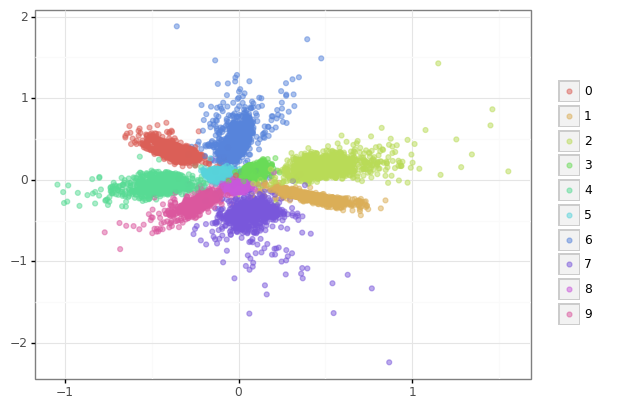

<ggplot: (152375350839)>

In [14]:
from plotnine import ggplot, aes, geom_line,geom_point,theme_bw,scale_color_hue,ggsave,geom_label

#sample=coded_test[indices]
sample=coded_test
n=50
nugde=np.max(np.abs(sample))*0.01/3

plot=ggplot() +\
geom_point(aes(x=sample[:,0], y=sample[:,1], color=np.round(sample[:,2]).astype('int32').astype('str')),alpha=0.5) +\
scale_color_hue(name=' ')+\
theme_bw()

ggsave(plot=plot, filename='Modelo hibrido completo.png', dpi=200)

ggplot() +\
geom_point(aes(x=sample[:,0], y=sample[:,1], color=np.round(sample[:,2]).astype('int32').astype('str')),alpha=0.5) +\
scale_color_hue(name=' ')+\
theme_bw()

ValueError: too many values to unpack (expected 2)

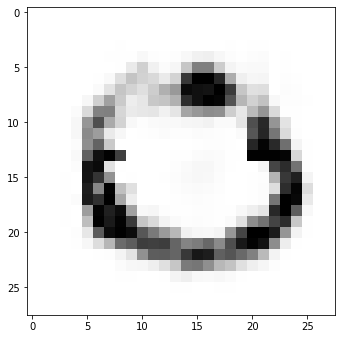

In [66]:
plt.figure(figsize=(6.4*5,6.4*1))

for i in range(10):
    ref=coded_test[test_y==i]
    media=np.mean(ref,axis=0)
    cov=np.cov(ref,rowvar=False)
    for j in range(5):
        noise=np.random.multivariate_normal(media, cov)
        
        plt.subplot(1, 5, j+1)
        
        sample=(media+noise).reshape([1,2])
        fig=plt.imshow(destransf(Decoder1.predict(sample)).reshape([28,28]),cmap='Greys')
        plt.annotate(str(np.around(sample,2).flatten().tolist()),[0.0,0.0,1],fontsize=20)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    
    plt.savefig('digito'+str(i)+'.png')

In [72]:
ax

<AxesSubplot:>

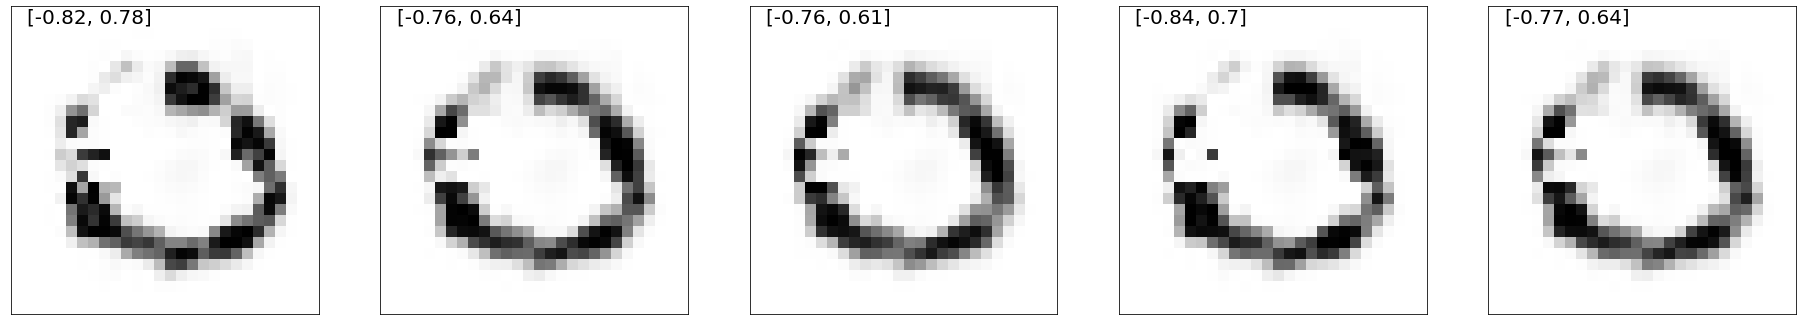

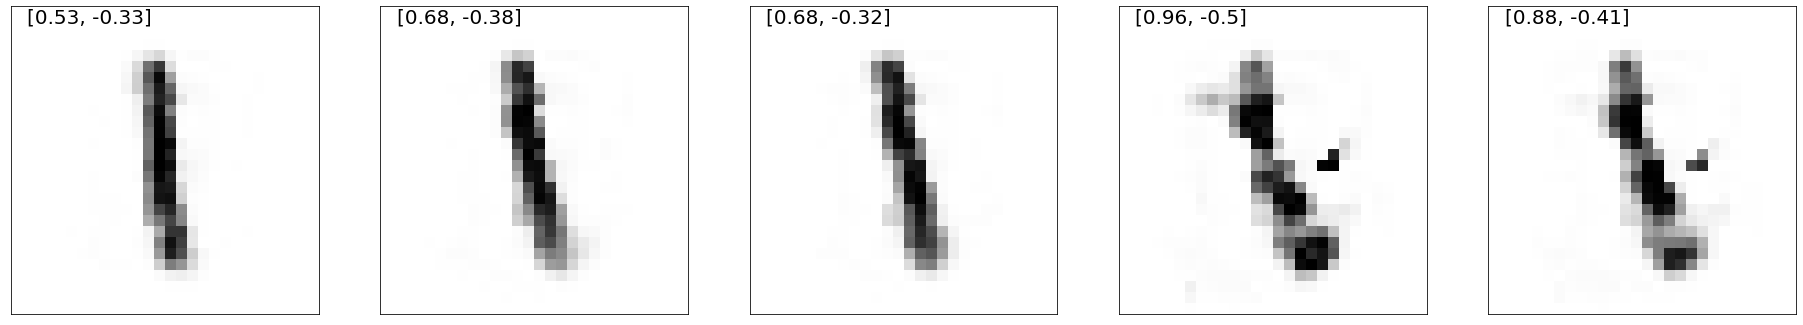

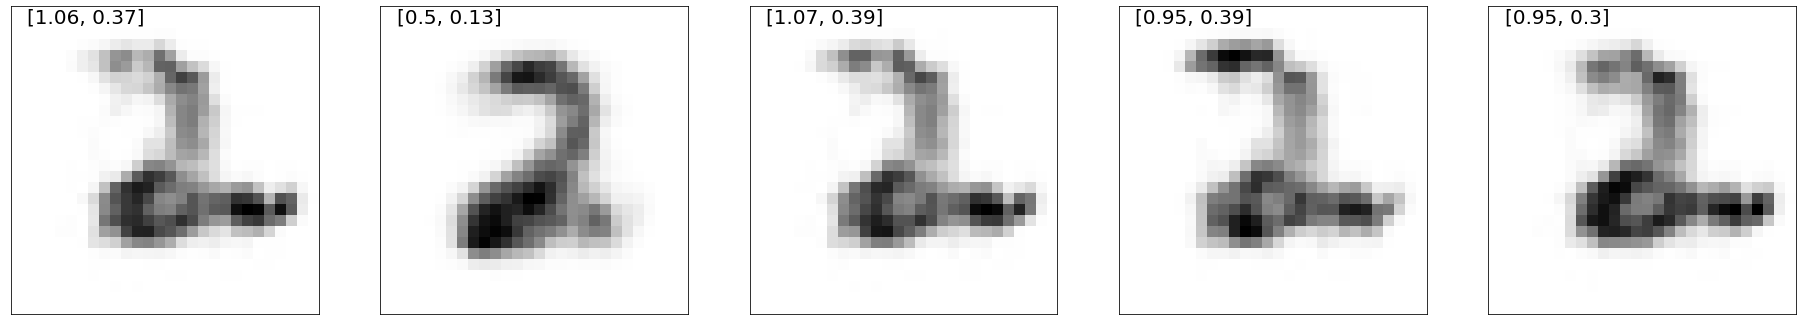

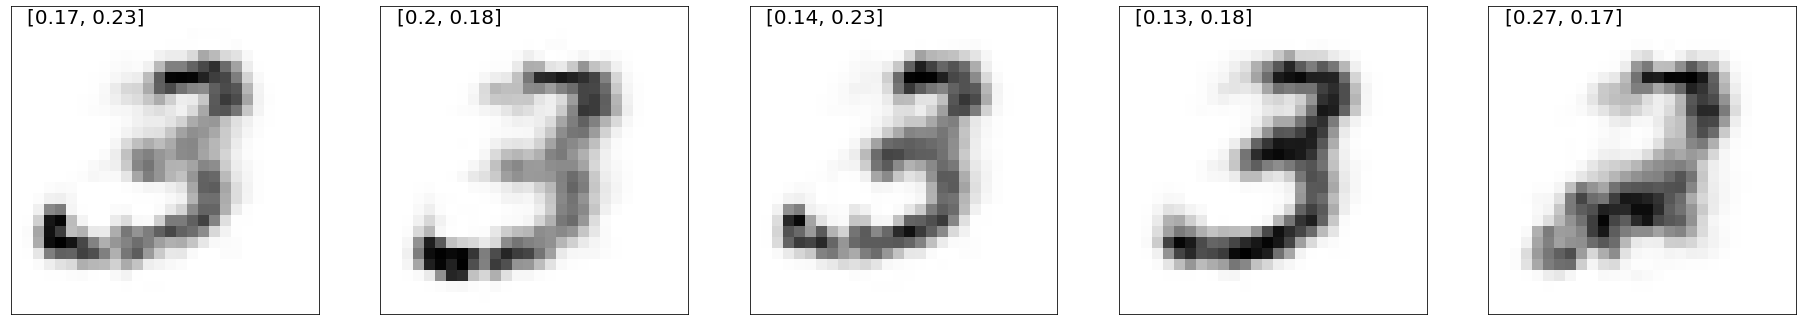

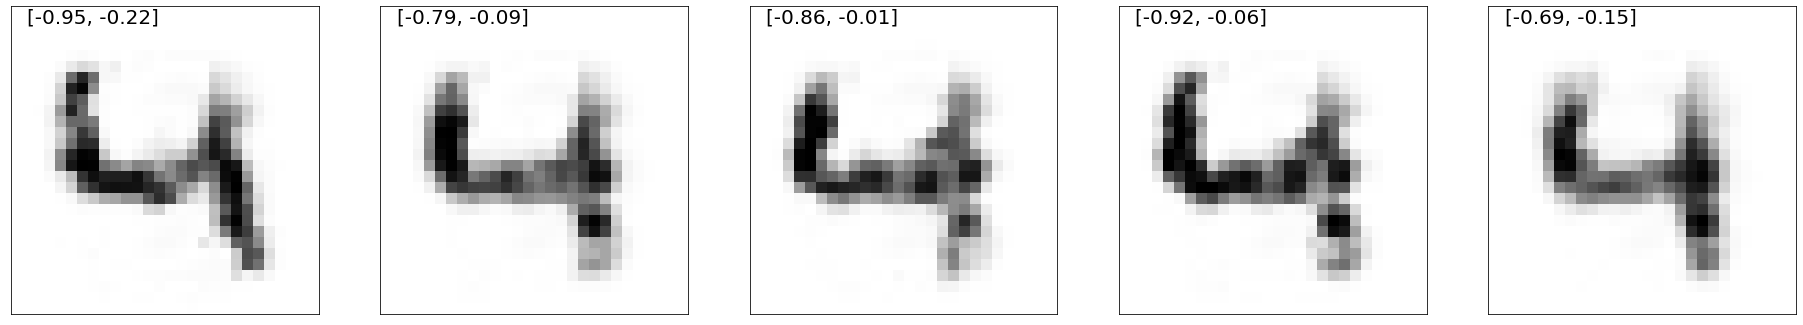

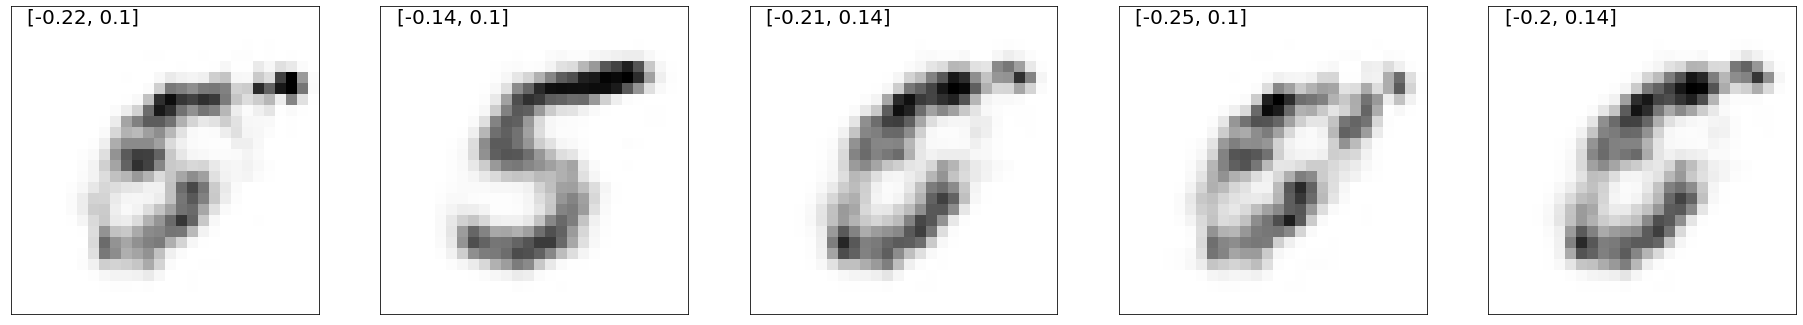

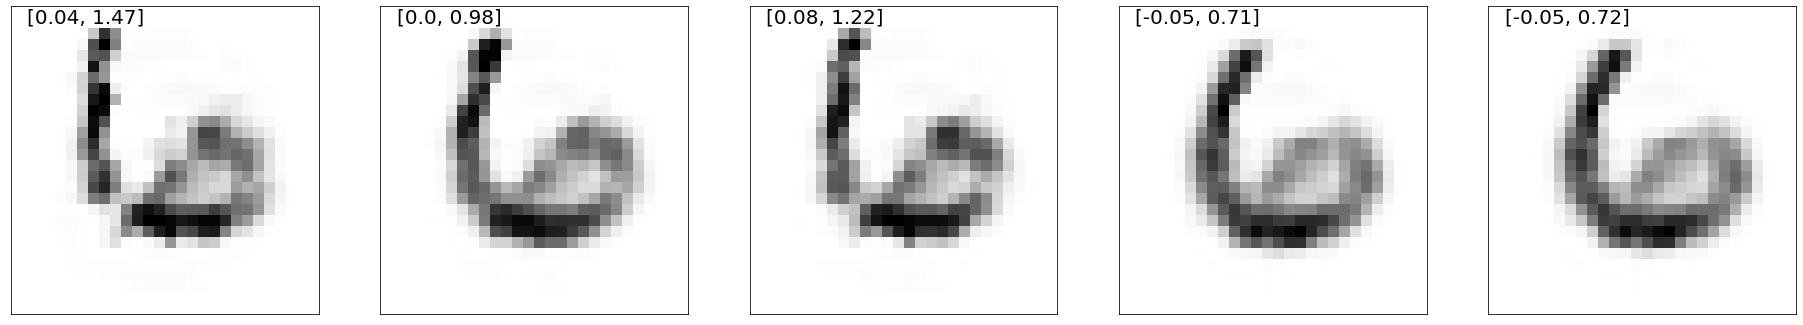

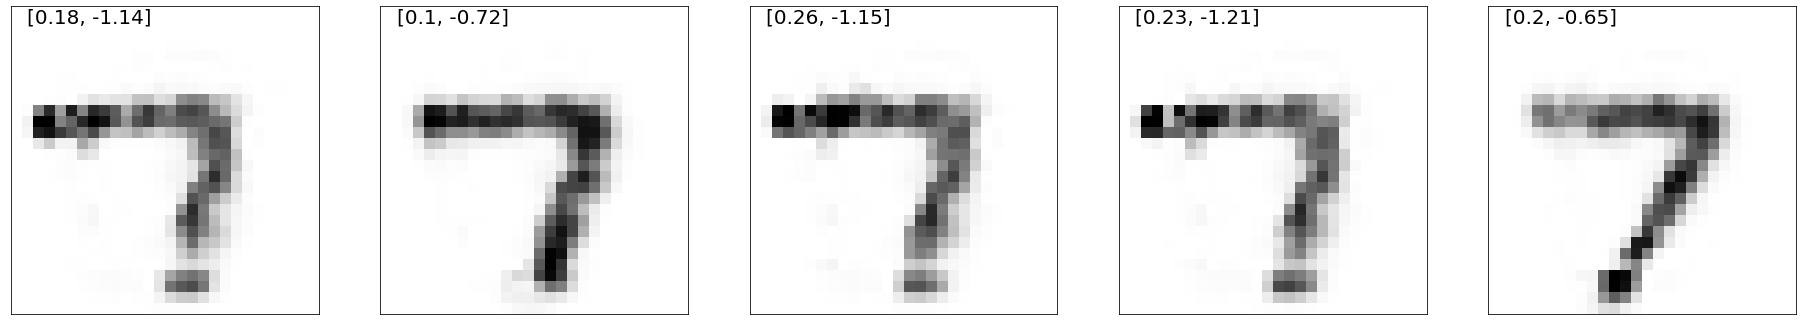

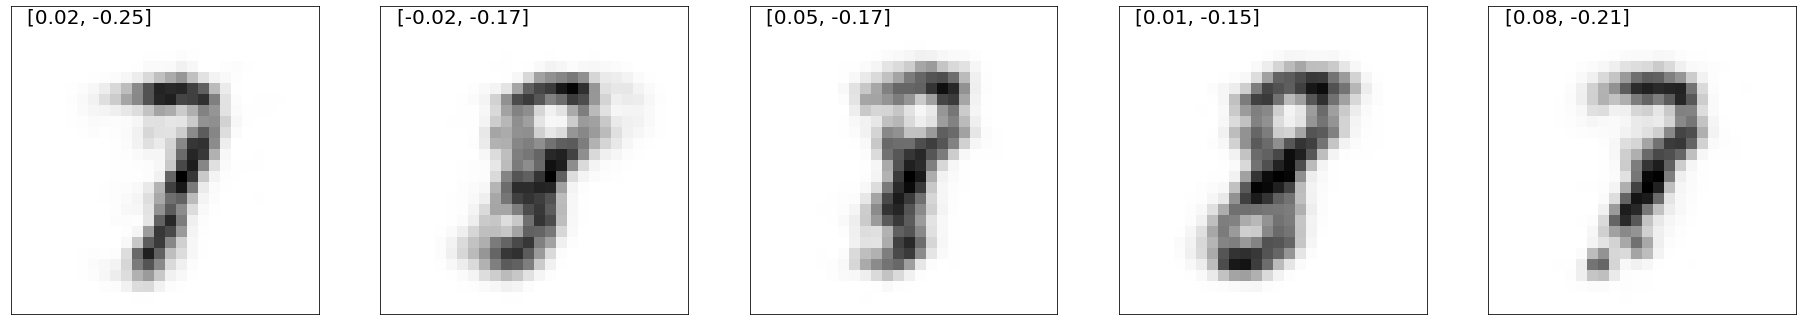

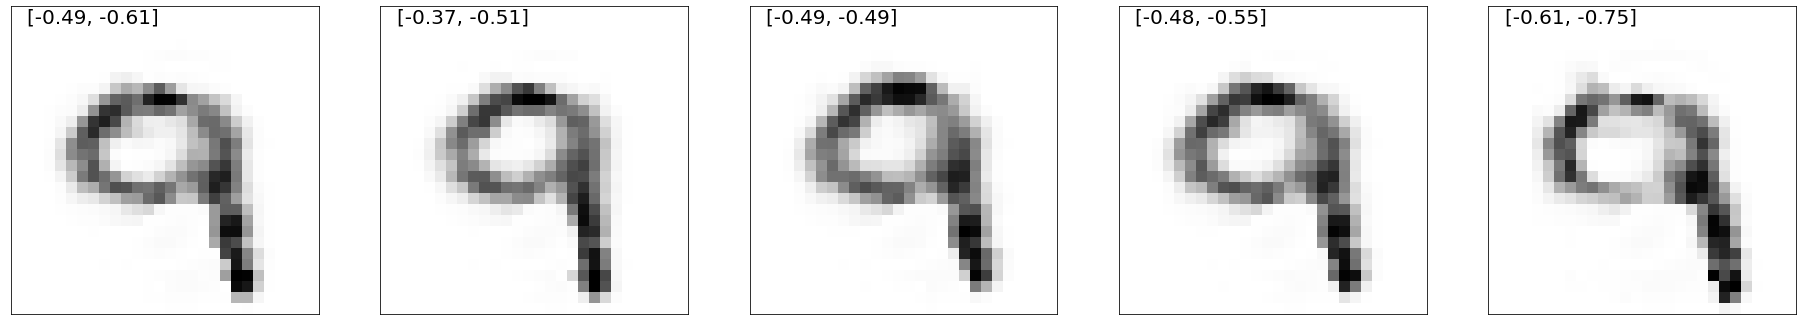

In [78]:
for i in range(10):
    ref=coded_test[test_y==i]
    media=np.mean(ref,axis=0)
    cov=np.cov(ref,rowvar=False)
    fig,ax=plt.subplots(1, 5,figsize=(6.4*5,6.4*1))
    for j in range(5):
        noise=np.random.multivariate_normal(media, cov)
        
        sample=(media+noise).reshape([1,2])
        ax[j].imshow(destransf(Decoder1.predict(sample)).reshape([28,28]),cmap='Greys')
        ax[j].annotate(str(np.around(sample,2).flatten().tolist()),[1.0,1.0],fontsize=20)
        ax[j].axes.get_xaxis().set_visible(False)
        ax[j].axes.get_yaxis().set_visible(False)
    
    plt.savefig('digito'+str(i)+'.png')

In [ ]:
plt.figure(figsize=(6.4*5,6.4*2))

for i in range(10):
    
    teste=np.zeros([1,10],dtype=float_type)
    teste[0,i]=1
    plt.subplot(2, 5, i+1)
    fig=plt.imshow(destransf(Decoder.predict(teste)).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
plt.savefig('Encoded_values_10.png')

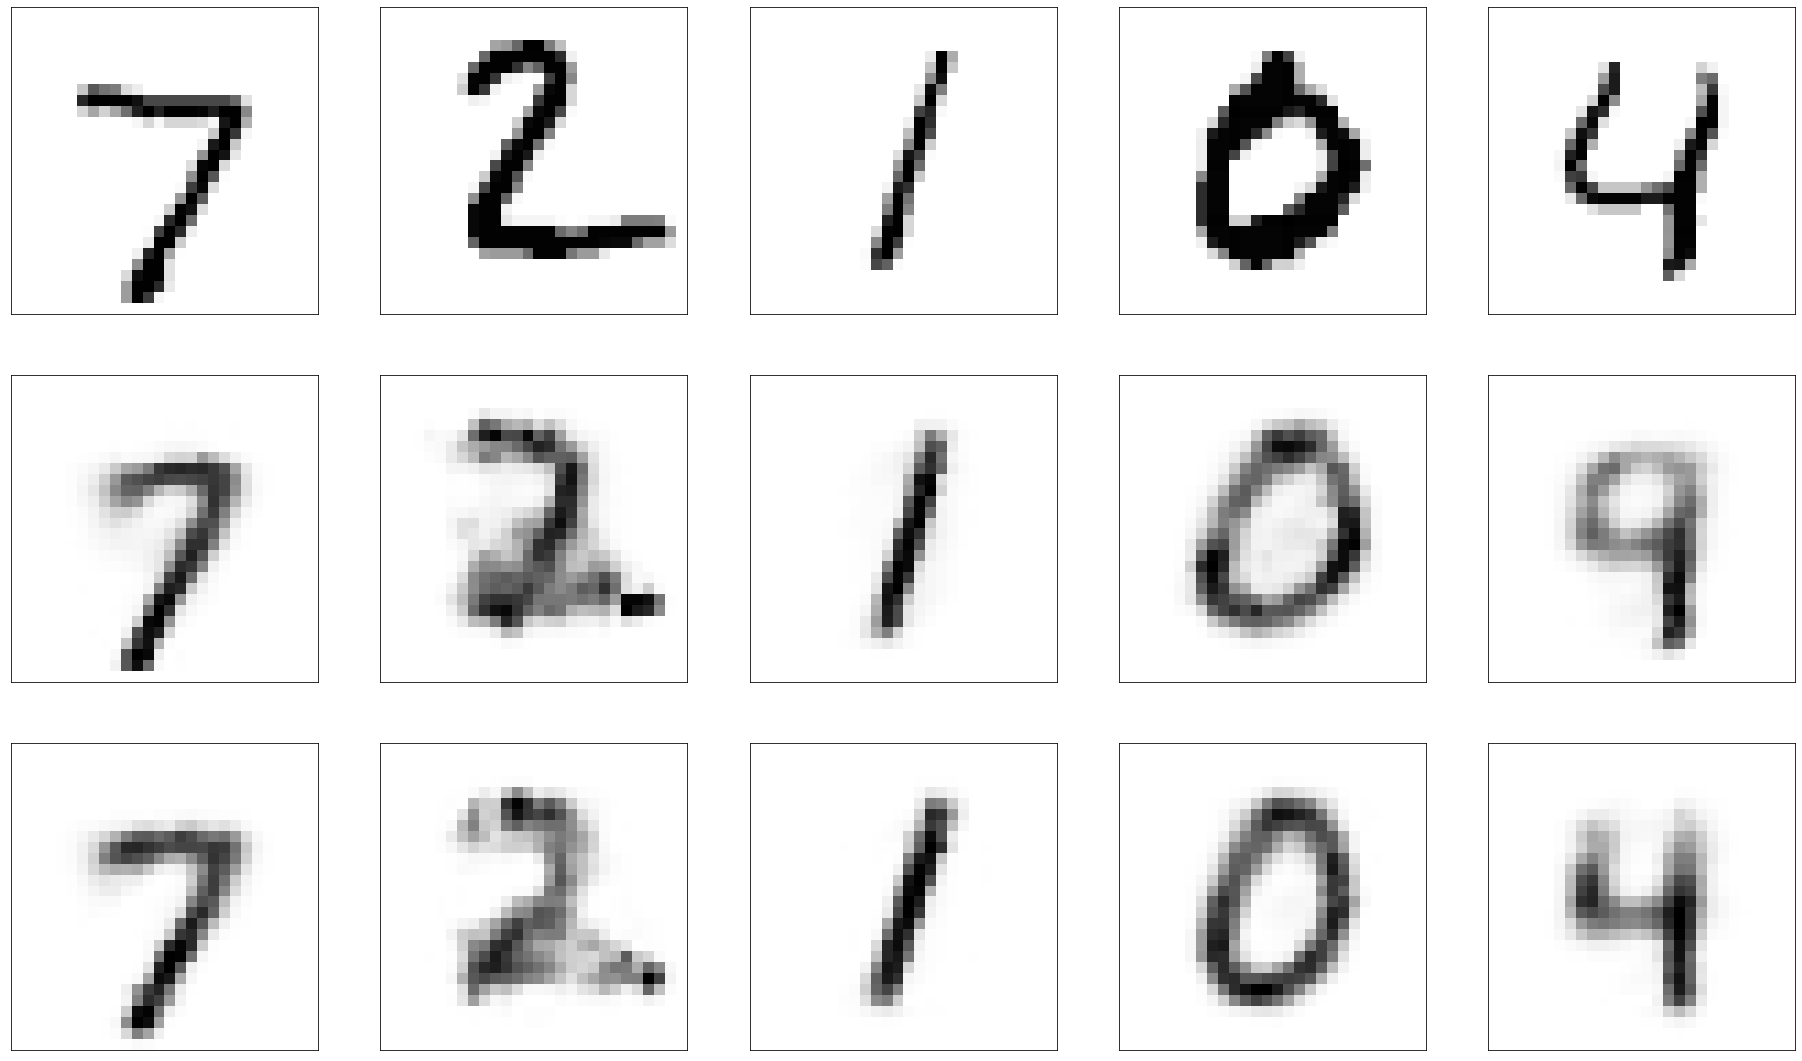

In [34]:
plt.figure(figsize=(6.4*5,6.4*3))

for i in range(5):
    plt.subplot(3, 5, i+1)
    fig=plt.imshow(destransf(test_x[i]).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    fig=plt.imshow(destransf(Network.predict(test_x[i:i+1])[0]).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+11)
    fig=plt.imshow(destransf(Network_h.predict(test_x[i:i+1])[0]).reshape([28,28]),cmap='Greys')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
plt.savefig('Encoded_model_hibrid.png')

In [ ]:
Encoder.predict(test_x)

In [ ]:
coded_test[:n,2]